# Making a figure showing $\xi_{\rm hm}$

This notebook is used to make a figure for the halo bais paper. It will use some modules that aren't dependencies of this one, so it likely won't run for a user.

In [1]:
import numpy as np
import bias_emulator
import hmf_emulator
import ximm_emulator
import aemulus_data as AD
import aemulus_extras as ae
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
%matplotlib inline

In [2]:
plt.rc("font", size=16, family="serif")
plt.rc("errorbar", capsize=3)
plt.rc("text", usetex=True)

In [3]:
cosmo_index = 3
#Note: we remove sigma8 from the list of parameters
cosmology = AD.test_box_cosmologies()[cosmo_index][:-1]
cosmo_dict = {"omega_b":cosmology[0], "omega_cdm":cosmology[1], "w0":cosmology[2],
             "n_s":cosmology[3], "ln10As":cosmology[4],"H0":cosmology[5],"N_eff":cosmology[6]}
print("Cosmology for testing simulation 3 loaded")
Extras = ae.Extras(cosmo_index, testing=True)

Cosmology for testing simulation 3 loaded


In [4]:
#Create our emulators
ximm_emu = ximm_emulator.ximm_emulator(cosmology)
ximm_all = ximm_emu.predict(cosmology)
bias_emu = bias_emulator.bias_emulator()
bias_emu.set_cosmology(cosmo_dict)
hmf_emu = hmf_emulator.hmf_emulator()
hmf_emu.set_cosmology(cosmo_dict)

CLASS is computing
	CLASS done


In [5]:
#Load in data
zi = 9
redshift = 0

datapath = "./data_for_plots/"
_, Mlos, Mhis, Masses = np.loadtxt(datapath+"TestBox003-000_Z%d_halo_means_hmcf.txt"%zi, unpack=True)
#Fix this part - the input file has an inf for the last entry
Mhis[-1] = 10**16.5

In [6]:
#Write a function to get the correct bin-averaged bias
Marr = np.logspace(np.log10(Mlos[0]), np.log10(Mhis[-1]), 1000)
lnMarr = np.log(Marr)
bias_at_Marr = bias_emu.bias(Marr, redshift)
dndM_at_Marr = hmf_emu.dndM(Marr, redshift)

def bias_bin_ave(Mlo, Mhi):
    lnMlo = np.log(Mlo)
    lnMhi = np.log(Mhi)
    
    bhmf_spl = IUS(lnMarr, bias_at_Marr*dndM_at_Marr*Marr)
    hmf_spl = IUS(lnMarr, dndM_at_Marr*Marr)
    return bhmf_spl.integral(lnMlo, lnMhi) / hmf_spl.integral(lnMlo, lnMhi)

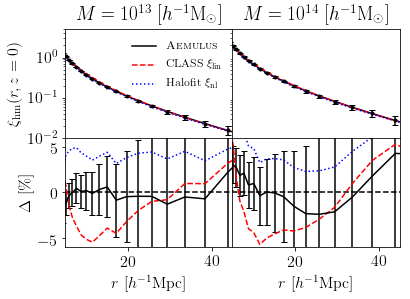

In [9]:
#Plot some predictions
fig, ax = plt.subplots(ncols=2, nrows=2)#, sharex=True)
plt.subplots_adjust(hspace=0, wspace=0)
ax[0,0].set_xlim(5, 45)
ax[0,1].set_xlim(5, 45)
ax[1,0].set_xlim(5, 45)
ax[1,1].set_xlim(5, 45)

ax[0,0].set_yscale("log")
ax[0,1].set_yscale("log")
ax[0,0].set_ylim(.01, 5)
ax[0,1].set_ylim(.01, 5)
#ax[0,0].set_ylim(.5, 20)
#ax[0,1].set_ylim(.5, 20)
#ax[0,0].set_ylim(10, 200)
#ax[0,1].set_ylim(10, 200)
yl = 6
ax[1,0].set_ylim(-yl, yl)
ax[1,1].set_ylim(-yl, yl)

ax[0,0].set_xticks([])
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
ax[1,1].set_yticks([])
ax[1,0].axhline(0, c='k', ls='--')
ax[1,1].axhline(0, c='k', ls='--')

for count, mi in enumerate([3, 15]):
    #ax[0,count].set_title(r"$\log_{10}M = %.0f\ [h^{-1}{\rm M}_\odot]$"%(np.log10(Masses[mi])))
    ax[0,count].set_title(r"$M = 10^{%.0f}\ [h^{-1}{\rm M}_\odot]$"%(np.log10(Masses[mi])))
    
    r = np.load(datapath+"r.npy")
    xi = np.load(datapath+"TestBox003_combined_Z9_DS50_M%d_hmcf.npy"%mi)
    cov = np.load(datapath+"TestBox003_combined_Z9_DS50_M%d_hmcf_cov.npy"%mi)
    errorbar = np.sqrt(cov.diagonal())
    ax[0, count].errorbar(r, xi, errorbar, c='k', ls='', marker='.')
    
    ximm = ximm_all[zi]
    #bias = bias_emu.bias(Masses[mi], redshift)
    bias = bias_bin_ave(Mlos[mi], Mhis[mi])
    ax[0, count].plot(r, ximm*bias, c='k', label=r"{\sc Aemulus}")
    pd = (xi-ximm*bias)/(ximm*bias)*100
    pde = errorbar/(ximm*bias)*100
    ax[1, count].errorbar(r, pd, pde, c='k')
    #ax[1, count].plot(r, pd, c='k')

    ximm = Extras.xi_lin[zi]
    ax[0, count].plot(Extras.r, ximm*bias, c='r', ls="--", label=r"CLASS $\xi_{\rm lin}$")
    spl = IUS(Extras.r, ximm*bias)
    pd = (xi-spl(r))/spl(r)*100
    pde = errorbar/spl(r)*100
    #ax[1, count].errorbar(r, pd, pde, c='r', ls='--')
    ax[1, count].plot(r, pd, c='r', ls='--')
    
    ximm = Extras.xi_nl[zi]
    ax[0, count].plot(Extras.r, ximm*bias, c='b', ls=":", label=r"Halofit $\xi_{\rm nl}$")
    spl = IUS(Extras.r, ximm*bias)
    pd = (xi-spl(r))/spl(r)*100
    pde = errorbar/spl(r)*100
    #ax[1, count].errorbar(r, pd, pde, c='b', ls=':')
    ax[1, count].plot(r, pd, c='b', ls=':')

    
ax[0,0].legend(frameon=False, fontsize=12)
ax[0,0].set_ylabel(r"$\xi_{\rm hm}(r,z=%.0f)$"%redshift)
ax[1,0].set_ylabel(r"$\Delta\ [\%]$")
ax[1,0].set_xlabel(r"$r\ [h^{-1}{\rm Mpc}]$")
ax[1,1].set_xlabel(r"$r\ [h^{-1}{\rm Mpc}]$")
fig.savefig("xihm_model_comparison.pdf", dpi=300, bbox_inches="tight")